# LeNet5 for MNIST digits classification

In this notebook I will use a LeNet5 implementation using tensorflow keras API for the problem of handwritten digits classifcation. This is tribute to he man who created the data set and the performance of this CNN is very satisfying for not an acceptable number of parameters.

In [60]:
import numpy as np 
import pandas as pd 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage
import matplotlib.pyplot as plt
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


## Loading the data

I start by loading the data onto the notebook by using Pandas as the format is CSV.**

In [3]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

Then I quickly visualize the five first rows of the data using the head() method from pandas

In [4]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Convert the panda dataframe into a numpy array

Convert the panda dataframe to a numpy array. Shuffle the data using a sklearn tool and show a random example image.

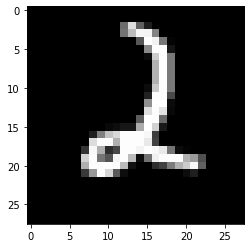

In [5]:
data_as_np = data.to_numpy()
labels = data_as_np[:,0].reshape((42000,1)) #To avoid having issues with arrays of np shape (42000,)
pixels = data_as_np[:,1:].reshape((42000,28,28,1)) / 255 # normalizing the inputs

labels, pixels = shuffle(labels, pixels)

r = int(np.random.uniform(0,41999))
digit=pixels[r,:,:,0] * 255 #pyplot expects a 2D array for a gray scale image
plt.imshow(digit, cmap=plt.cm.gray)   

## Split the data 

We want to split the data we have into a training set and a crossing validation set. I will not use a test set in this application as we do not have a lot of data and we want to maximise the potential of what we have.

I have taken a 80:20 split for this task.


In [6]:
X_train, X_CV, y_train, y_CV = train_test_split(pixels, labels, test_size = 0.2 )

print(f'Training data: \nX_train shape : {X_train.shape} and y_train shape : {y_train.shape}\n')
print(f'Cross validation data: \nX_CV shape : {X_CV.shape} and y_CV shape : {y_CV.shape}')

Training data: 
X_train shape : (33600, 28, 28, 1) and y_train shape : (33600, 1)

Cross validation data: 
X_CV shape : (8400, 28, 28, 1) and y_CV shape : (8400, 1)


## Time to build the model v1

For this first version of my submission of the MNIST competition i will build a CNN similar to the LeNet5. Using tensorflow and Keras API.

In [7]:
inputs = keras.Input(shape = (28,28,1))

conv1 = layers.Conv2D(6, (5,5), strides = (1,1), activation = 'tanh')
x = conv1(inputs)

x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(16, (5,5), strides = (1,1), activation = 'tanh')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(120, activation = 'tanh')(x)
x = layers.Dense(84, activation = 'tanh')(x)

outputs = layers.Dense(10, activation = 'softmax')(x)

model = keras.Model(inputs = inputs, outputs = outputs, name="MNISTv1")

model.summary()

Model: "MNISTv1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               3084

## Compile the model

Now I will compile the model and choose ADAM optimiztion algorithm.

In [8]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
             optimizer = keras.optimizers.Adam(),
             metrics = ['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=5)

Train on 33600 samples
Epoch 1/5
33600/33600 [==============================] - 10s 292us/sample - loss: 0.3195 - accuracy: 0.9047
Epoch 2/5
33600/33600 [==============================] - 9s 277us/sample - loss: 0.1280 - accuracy: 0.9607
Epoch 3/5
33600/33600 [==============================] - 9s 274us/sample - loss: 0.0875 - accuracy: 0.9733
Epoch 4/5
33600/33600 [==============================] - 9s 274us/sample - loss: 0.0643 - accuracy: 0.9795
Epoch 5/5
33600/33600 [==============================] - 9s 278us/sample - loss: 0.0511 - accuracy: 0.9840


## Cross validate the model on an unknown set

Now that our model is trained with a good accuracy on the training dataset (more than 98% with just 40k parameters!), we can check the values on unknown values and see the performances.

In [9]:
test = model.evaluate(X_CV, y_CV, verbose=2)

8400/8400 - 1s - loss: 0.0768 - accuracy: 0.9783


## Remarks

Our cross validation accuracy is slightly inferior to the train accuracy at 97.83% on my model. That means that the model is actually overfitting sightly the training set.

Possible solutions to improve the overfiting (one or a combination of the following):

- Add regularisation to the loss funciton
- Add dropouts layers
- Increase training data by means of data augmentation


Also, it is probably possible to train a bigger network on this data, then we would definitely need to use data augmentation techniques.

## Prediction

Finally we need to make prediction on an unknown data using our model. We will then convert the results in a csv files for submission for the kaggle competition. 

### Inference times

We can see that the inference time for a 28 000 batch size is less than 4 seconds. This would go up if we did data augmentation at run time to enhance the performance or if we used several models to predict.

In [73]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test_as_np = test.to_numpy()

pixels_test = test_as_np.reshape((28000,28,28,1)) / 255

tic = time.time()
result = model.predict(pixels_test, batch_size=32)
toc = time.time()

elapsed = (toc-tic)*1000
print(f'The inference time on the 28 000 batch size is {elapsed} ms')


result = result.argmax(axis=1).reshape((28000,1))

The inference time on the 28 000 batch size is 3898.545265197754 ms


## Prediction on a single example

We can compute the inference time on a single example and check if our model work properly.

0.16707182873149262
The result is [9] and the inference time to output that result is 31.569719314575195 ms
this is the shit 
 0.16707182873149262


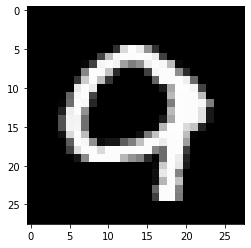

In [90]:
i = int(np.random.uniform(0,27999))

tic = time.time()
inference = model.predict(pixels_test[i:i+1,:,:,:])
toc = time.time()

elapsed = (toc-tic)*1000

print(f'The result is {inference.argmax(axis=1)} and the inference time to output that result is {elapsed} ms')

#print(np.average(pixels_test[i:i+1,:,:,:]))
#print('this is the shit \n',np.average(pixels_test[i,:,:,0])) #Theses two lines can be used to make sure we are looking at the same example.
digit=pixels_test[i,:,:,0] * 255 
plt.imshow(digit, cmap=plt.cm.gray)  

## Postprocessing

We need to convert the results in a csv files for submission for the kaggle competition. The exact shape should have the id of the test exmaple and the class predcited.

In [47]:
a = np.arange(28000).reshape((28000,1))
test_result = np.concatenate((a, result), axis = 1)

print(test_result)

[[    0     2]
 [    1     0]
 [    2     9]
 ...
 [27997     3]
 [27998     9]
 [27999     2]]


## Save as a CSV file

Finally, we have the data well ordered and everything is ready to create and submit the CSV file.

In [57]:
np.savetxt('test.csv', test_result, fmt='%i', delimiter=',', header="#ImageId, #Label")

In [58]:
check = pd.read_csv('/kaggle/working/test.csv')
check.head(10)

,# #ImageId,#Label
0,0,2
1,1,0
2,2,9
3,3,0
4,4,3
5,5,7
6,6,0
7,7,3
8,8,0
9,9,3
